<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Stuff

###Import all libraries

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
import re

###Import datasets

In [2]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
city_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/city/ACSST1Y2022.S0101-Data.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')

#Data Cleaning

In [3]:
#only consider 2022 crime data from cities and counties
crime_df = crime_df[(crime_df['data_year'] == 2022) & ((crime_df['agency_type_name'] == "City") | (crime_df['agency_type_name'] == "County"))]

In [4]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [5]:
#fix the headers
city_demo_df = fixHeaders(city_demo_df)
county_demo_df = fixHeaders(county_demo_df)

In [6]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [7]:
splitArea(city_demo_df)
splitArea(county_demo_df)

# city_demo_df.head()

In [8]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"].map(split_incident_date).apply(pd.Series)

In [9]:
def fix_columns(df):
  removalList = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_columns(county_demo_df)
city_demo_df.columns = fix_columns(city_demo_df)

In [10]:
def preprocess_city_df(df_s0101):
    formatted_df = df_s0101.copy(deep=True)

    formatted_df['25 to 34 years'] = df_s0101['25 to 29 years'] + df_s0101['30 to 34 years']
    formatted_df['35 to 44 years'] = df_s0101['35 to 39 years'] + df_s0101['40 to 44 years']
    formatted_df['45 to 54 years'] = df_s0101['45 to 49 years'] + df_s0101['50 to 54 years']
    formatted_df['65 to 74 years'] = df_s0101['65 to 69 years'] + df_s0101['70 to 74 years']
    formatted_df['75 to 84 years'] = df_s0101['75 to 79 years'] + df_s0101['80 to 84 years']

    return formatted_df

city_demo_df = preprocess_city_df(city_demo_df)
# city_demo_df

###Combine the datasets

In [11]:
# Create new columns that combine data shared between all the city and county entries
overlapping_columns = set(city_demo_df.columns).intersection(set(county_demo_df.columns))
print(overlapping_columns)
demo_df = pd.concat([city_demo_df[list(overlapping_columns)],county_demo_df[list(overlapping_columns)]])

{'Percent!!85 years and over', 'Margin of Error!!20 to 24 years', 'Percent!!Total population', 'Percent!!20 to 24 years', 'Margin of Error!!60 to 64 years', 'Total population', '20 to 24 years', '15 to 19 years', 'Percent!!5 to 9 years', 'Margin of Error!!10 to 14 years', 'Margin of Error!!5 to 9 years', 'Percent!!55 to 59 years', 'Geographic Area Name', '60 to 64 years', '85 years and over', 'Geography', 'Under 5 years', '10 to 14 years', 'Margin of Error!!15 to 19 years', 'Margin of Error!!55 to 59 years', '35 to 44 years', 'agency_type_name', '65 to 74 years', 'Percent!!60 to 64 years', 'pug_agency_name', '75 to 84 years', '25 to 34 years', 'Margin of Error!!Total population', 'Margin of Error!!85 years and over', 'state_name', '45 to 54 years', 'Percent!!10 to 14 years', 'Percent!!15 to 19 years', 'nan', '55 to 59 years', '5 to 9 years', 'Percent!!Under 5 years', 'Margin of Error!!Under 5 years'}


In [12]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, demo_df, on=["pug_agency_name", "agency_type_name", "state_name"])

###Clean the merged dataset

In [13]:
merged_df.drop(["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "nan", "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit"], axis=1, inplace=True)
merged_df.drop(list(merged_df.filter(regex = "Margin of Error")), axis = 1, inplace = True)

In [14]:
merged_df = merged_df.replace("(X)", np.nan)

In [15]:
# Convert object columns to string dtype
object_columns = ["pug_agency_name", "agency_type_name", "state_name", "division_name", "offender_race",
                  "offender_ethnicity", "offense_name", "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"]
merged_df[object_columns] = merged_df[object_columns].astype(str)

# Number columns
int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years", "10 to 14 years", "75 to 84 years", "60 to 64 years",
                      "25 to 34 years", "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years", "65 to 74 years",
                      "85 years and over", "incident_month", "incident_day"]
merged_df[int_columns] = merged_df[int_columns].astype(int)

# Convert columns with percentage values to float
percentage_columns = ["Percent!!60 to 64 years", "Percent!!15 to 19 years", "Percent!!5 to 9 years", "Percent!!10 to 14 years",
                      "Percent!!Under 5 years", "Percent!!20 to 24 years", "Percent!!55 to 59 years", "Percent!!85 years and over"]
merged_df[percentage_columns] = merged_df[percentage_columns].astype(float)

merged_df.dtypes

incident_id                     int64
data_year                      object
pug_agency_name                object
agency_type_name               object
state_name                     object
division_name                  object
region_name                    object
adult_victim_count            float64
juvenile_victim_count         float64
total_offender_count            int64
adult_offender_count          float64
juvenile_offender_count       float64
offender_race                  object
offender_ethnicity             object
victim_count                    int64
offense_name                   object
total_individual_victims      float64
location_name                  object
bias_desc                      object
victim_types                   object
multiple_offense               object
multiple_bias                  object
incident_month                  int64
incident_day                    int64
Percent!!85 years and over    float64
Percent!!20 to 24 years       float64
Total popula

# Explore the Data

##Individual Datasets

###Hate Crime Dataset

In [16]:
pd.set_option('display.max_columns', 50)

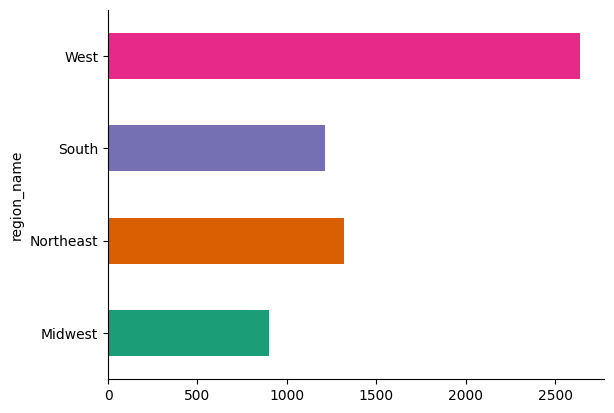

In [17]:
merged_df.groupby('region_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

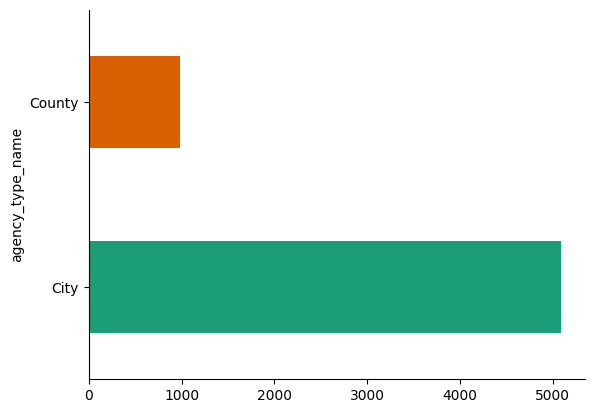

In [18]:
merged_df.groupby('agency_type_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

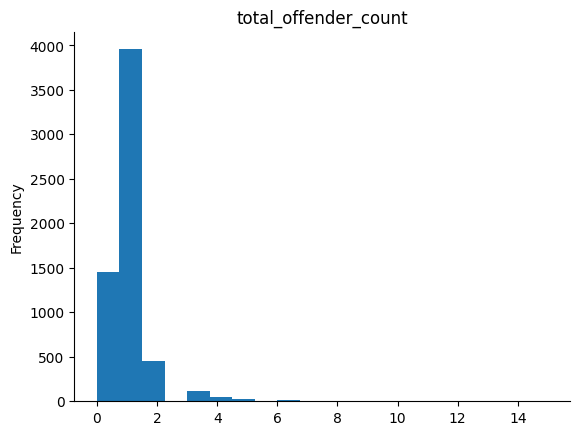

In [19]:
merged_df['total_offender_count'].plot(kind='hist', bins=20, title='total_offender_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

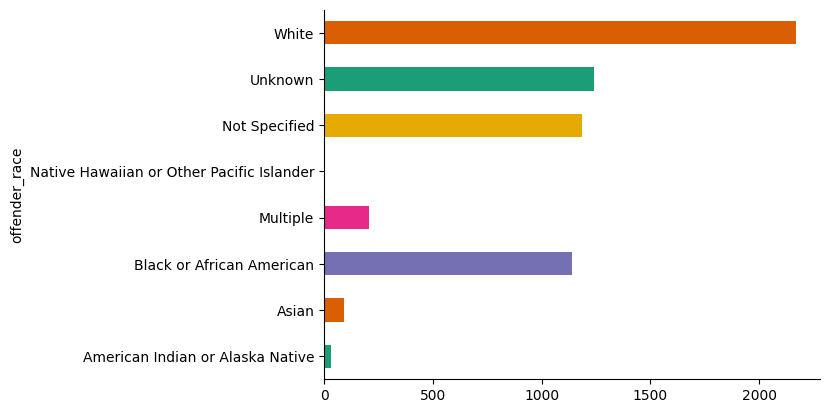

In [20]:
merged_df.groupby('offender_race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

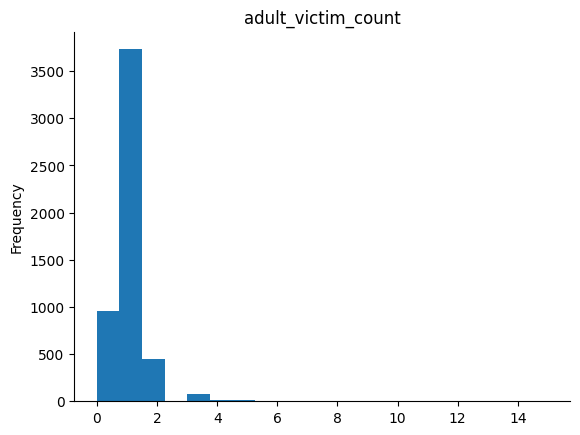

In [21]:
merged_df['adult_victim_count'].plot(kind='hist', bins=20, title='adult_victim_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

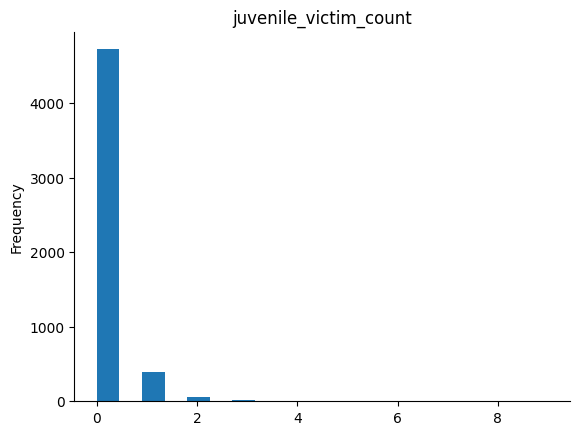

In [22]:
merged_df['juvenile_victim_count'].plot(kind='hist', bins=20, title='juvenile_victim_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

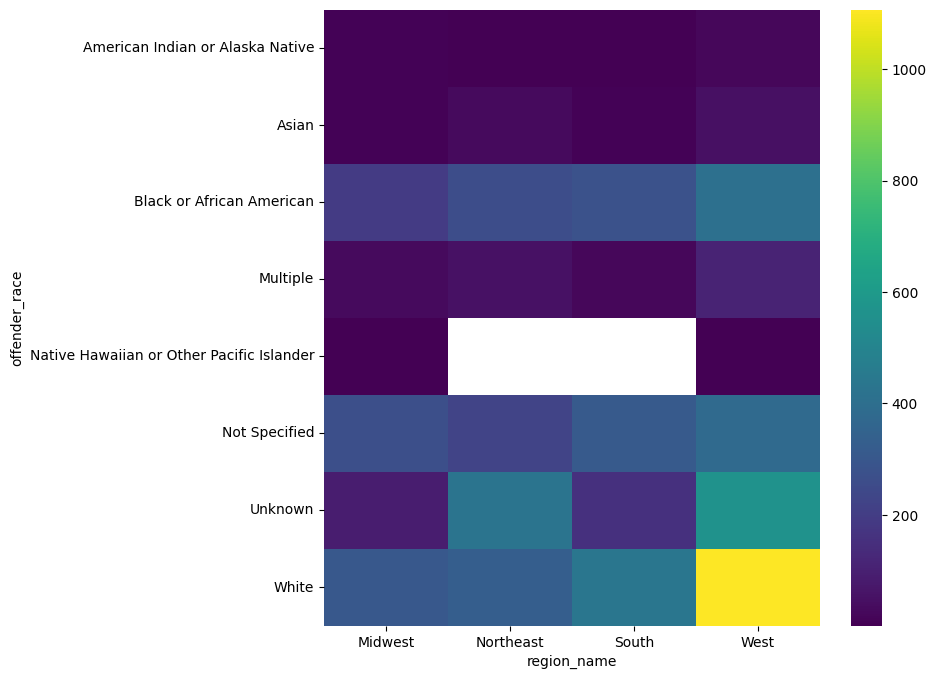

In [23]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in merged_df.groupby('region_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('region_name')
_ = plt.ylabel('offender_race')

###City Demographics Dataset

In [24]:
city_demo_df

,Geography,Geographic Area Name,Total population,Margin of Error!!Total population,Under 5 years,Margin of Error!!Under 5 years,5 to 9 years,Margin of Error!!5 to 9 years,10 to 14 years,Margin of Error!!10 to 14 years,15 to 19 years,Margin of Error!!15 to 19 years,20 to 24 years,Margin of Error!!20 to 24 years,25 to 29 years,Margin of Error!!25 to 29 years,30 to 34 years,Margin of Error!!30 to 34 years,35 to 39 years,Margin of Error!!35 to 39 years,40 to 44 years,Margin of Error!!40 to 44 years,45 to 49 years,Margin of Error!!45 to 49 years,50 to 54 years,...,Percent Female!!SELECTED AGE CATEGORIES!!75 years and over,Margin of Error!!Percent Female!!SELECTED AGE CATEGORIES!!75 years and over,Percent Female!!SUMMARY INDICATORS!!Median age (years),Margin of Error!!Percent Female!!SUMMARY INDICATORS!!Median age (years),Percent Female!!SUMMARY INDICATORS!!Sex ratio (males per 100 females),Margin of Error!!Percent Female!!SUMMARY INDICATORS!!Sex ratio (males per 100 females),Percent Female!!SUMMARY INDICATORS!!Age dependency ratio,Margin of Error!!Percent Female!!SUMMARY INDICATORS!!Age dependency ratio,Percent Female!!SUMMARY INDICATORS!!Old-age dependency ratio,Margin of Error!!Percent Female!!SUMMARY INDICATORS!!Old-age dependency ratio,Percent Female!!SUMMARY INDICATORS!!Child dependency ratio,Margin of Error!!Percent Female!!SUMMARY INDICATORS!!Child dependency ratio,Percent Female!!PERCENT ALLOCATED!!Sex,Margin of Error!!Percent Female!!PERCENT ALLOCATED!!Sex,Percent Female!!PERCENT ALLOCATED!!Age,Margin of Error!!Percent Female!!PERCENT ALLOCATED!!Age,nan,pug_agency_name,agency_type_name,state_name,25 to 34 years,35 to 44 years,45 to 54 years,65 to 74 years,75 to 84 years
1,1600000US0103076,"Auburn city, Alabama",80009,20,3657,1311,3809,1134,4348,1136,10742,1267,17844,1977,5960,1436,3991,1075,4609,1057,4276,1071,4078,948,4186,...,4.2,1.2,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN,Auburn,City,Alabama,59603991,46094276,40784186,16702139,1612639
2,1600000US0107000,"Birmingham city, Alabama",196353,868,11495,2020,11631,2173,9404,2476,12569,1638,17080,2690,19483,2642,15973,1986,9615,1947,12416,2027,10998,1885,10140,...,6.8,0.8,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN,Birmingham,City,Alabama,1948315973,961512416,1099810140,119177921,51592289
3,1600000US0121184,"Dothan city, Alabama",70524,678,4549,468,5059,662,4146,592,3971,660,4274,540,4897,426,5128,570,4286,684,4013,599,3057,459,4909,...,8.8,1.1,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN,Dothan,City,Alabama,48975128,42864013,30574909,46243535,23431651
4,1600000US0135896,"Hoover city, Alabama",92427,45,5778,1406,5805,1516,7377,2051,4891,1141,6165,1699,3150,1185,5578,1697,6873,1706,5639,1635,6980,1414,5218,...,10.9,2.5,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN,Hoover,City,Alabama,31505578,68735639,69805218,54203718,29162315
5,1600000US0137000,"Huntsville city, Alabama",222363,2301,12180,1698,13883,1837,10494,1917,15847,2158,18655,2320,16947,2060,17466,1677,14371,2376,14448,2084,13097,1514,12656,...,8.8,0.9,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN,Huntsville,City,Alabama,1694717466,1437114448,1309712656,116167971,77075137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,1600000US7210334,"Caguas zona urbana, Puerto Rico",68451,4611,2358,1088,2821,911,3158,1093,2590,915,5071,1244,4526,1180,4659,937,4837,1352,2873,1224,3710,779,4384,...,17.0,2.4,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN,Caguas zona urbana,Puerto Rico,NaN,45264659,48372873,37104384,47344547,51272382
643,1600000US7214290,"Carolina zona urbana, Puerto Rico",134842,3835,4403,276,6892,1150,5470,1144,7137,693,8703,733,9627,660,9229,591,6976,1383,8465,1299,8033,765,8527,...,15.4,0.7,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN,Carolina zona urb

###County Demographics Dataset

In [25]:
county_demo_df

,Geography,Geographic Area Name,Total population,Margin of Error!!Total population,Male,Margin of Error!!Male,Female,Margin of Error!!Female,Sex ratio (males per 100 females),Margin of Error!!Sex ratio (males per 100 females),Under 5 years,Margin of Error!!Under 5 years,5 to 9 years,Margin of Error!!5 to 9 years,10 to 14 years,Margin of Error!!10 to 14 years,15 to 19 years,Margin of Error!!15 to 19 years,20 to 24 years,Margin of Error!!20 to 24 years,25 to 34 years,Margin of Error!!25 to 34 years,35 to 44 years,Margin of Error!!35 to 44 years,45 to 54 years,...,Percent Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!American Indian and Alaska Native alone,Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone,Percent Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone,Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone,Percent Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone,Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone,Percent Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone,Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races,Percent Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races,Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race,Percent Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race,"Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races","Percent Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races",Percent!!Total housing units,Percent Margin of Error!!Total housing units,"Percent!!Citizen, 18 and over population","Percent Margin of Error!!Citizen, 18 and over population","Percent!!Citizen, 18 and over population!!Male","Percent Margin of Error!!Citizen, 18 and over population!!Male","Percent!!Citizen, 18 and over population!!Female","Percent Margin of Error!!Citizen, 18 and over population!!Female",nan,pug_agency_name,agency_type_name,state_name
1,0500000US01003,"Baldwin County, Alabama",246435,*****,120664,1277,125771,1277,95.9,2.0,12553,1274,15581,2058,13705,1900,13772,1190,12065,1164,28027,1366,29375,1299,32326,...,0.1,1.0,0.2,0.0,0.1,0.1,0.1,4.7,1.1,0.7,0.5,3.9,0.9,(X),(X),189876,(X),48.1,0.4,51.9,0.4,NaN,Baldwin,County,Alabama
2,0500000US01015,"Calhoun County, Alabama",115788,*****,56554,791,59234,791,95.5,2.6,6661,768,5376,1342,7505,1332,8145,1032,9623,1176,14606,1418,13115,1280,14388,...,0.1,0.8,0.3,0.1,0.2,1.3,1.6,2.3,0.8,0.3,0.3,2.0,0.8,(X),(X),90642,(X),47.8,0.3,52.2,0.3,NaN,Calhoun,County,Alabama
3,0500000US01043,"Cullman County, Alabama",90665,*****,45051,622,45614,622,98.8,2.7,5449,552,5785,769,5204,798,5545,551,5209,332,11930,548,10752,467,11341,...,0.2,0.3,0.3,0.1,0.1,0.2,0.3,3.1,0.9,1.0,0.7,2.1,0.6,(X),(X),69096,(X),49.0,0.6,51.0,0.6,NaN,Cullman,County,Alabama
4,0500000US01049,"DeKalb County, Alabama",71998,*****,36024,566,35974,566,100.1,3.2,4031,588,5086,853,4491,1057,5322,884,4693,558,8029,524,9479,822,8707,...,0.5,0.2,0.2,0.0,0.2,0.9,1.1,3.5,0.9,0.6,0.6,2.9,0.6,(X),(X),52110,(X),49.6,0.9,50.4,0.9,NaN,DeKalb,County,Alabama
5,0500000US01051,"Elmore County, Alabama",89563,*****,43448,541,46115,541,94.2,2.3,4519,64,4559,759,6623,822,5093,593,4907,1254,13068,1199,12284,795,11601,...,0.2,0.5,0.5,0.0,0.2,0.1,0.2,3.7,1.4,0.4,0.5,3.3,1.4,(X),(X),69952,(X),47.8,0.5,52.2,0.5,NaN,Elmore,County,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

##Merged Dataset

In [26]:
merged_df.head()

,incident_id,data_year,pug_agency_name,agency_type_name,state_name,division_name,region_name,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias,incident_month,incident_day,Percent!!85 years and over,Percent!!20 to 24 years,Total population,20 to 24 years,15 to 19 years,Percent!!5 to 9 years,Percent!!55 to 59 years,60 to 64 years,85 years and over,Under 5 years,10 to 14 years,35 to 44 years,65 to 74 years,Percent!!60 to 64 years,75 to 84 years,25 to 34 years,45 to 54 years,Percent!!10 to 14 years,Percent!!15 to 19 years,55 to 59 years,5 to 9 years,Percent!!Under 5 years
0,1433145,2022,Mobile,County,Alabama,East South Central,South,1.0,0.0,2,2.0,0.0,White,Not Hispanic or Latino,1,Simple Assault,1.0,Residence/Home,Anti-Asian;Anti-Black or African American,Individual,S,M,3,11,1.8,6.5,411411,26896,26649,6.1,6.1,27772,7554,25491,27573,50421,42741,6.8,21289,57435,47563,6.7,6.5,24935,25092,6.2
1,1468107,2022,Mobile,County,Alabama,East South Central,South,0.0,0.0,1,1.0,0.0,White,Not Hispanic or Latino,1,Destruction/Damage/Vandalism of Property,0.0,Residence/Home,Anti-White,Other,S,S,3,10,1.8,6.5,411411,26896,26649,6.1,6.1,27772,7554,25491,27573,50421,42741,6.8,21289,57435,47563,6.7,6.5,24935,25092,6.2
2,1468108,2022,Mobile,County,Alabama,East South Central,South,1.0,0.0,1,1.0,0.0,White,Not Hispanic or Latino,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,M,S,3,13,1.8,6.5,411411,26896,26649,6.1,6.1,27772,7554,25491,27573,50421,42741,6.8,21289,57435,47563,6.7,6.5,24935,25092,6.2
3,1475554,2022,Mobile,County,Alabama,East South Central,South,1.0,0.0,1,1.0,0.0,White,Not Hispanic or Latino,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S,5,31,1.8,6.5,411411,26896,26649,6.1,6.1,27772,7554,25491,27573,50421,42741,6.8,21289,57435,47563,6.7,6.5,24935,25092,6.2
4,1475556,2022,Mobile,County,Alabama,East South Central,South,1.0,0.0,1,1.0,0.0,Black or African American,Not Hispanic or Latino,1,Motor Vehicle Theft,1.0,Residence/Home,Anti-White,Individual,S,S,12,5,1.8,6.5,411411,26896,26649,6.1,6.1,27772,7554,25491,27573,50421,42741,6.8,21289,57435,47563,6.7,6.5,24935,25092,6.2


In [27]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df
# Select only the numerical columns
numerical_cols = categorical_to_int_df.select_dtypes(include=['int64', 'float64', np.number]).drop(labels=["incident_id"], axis=1)
# numerical_cols

<Axes: >

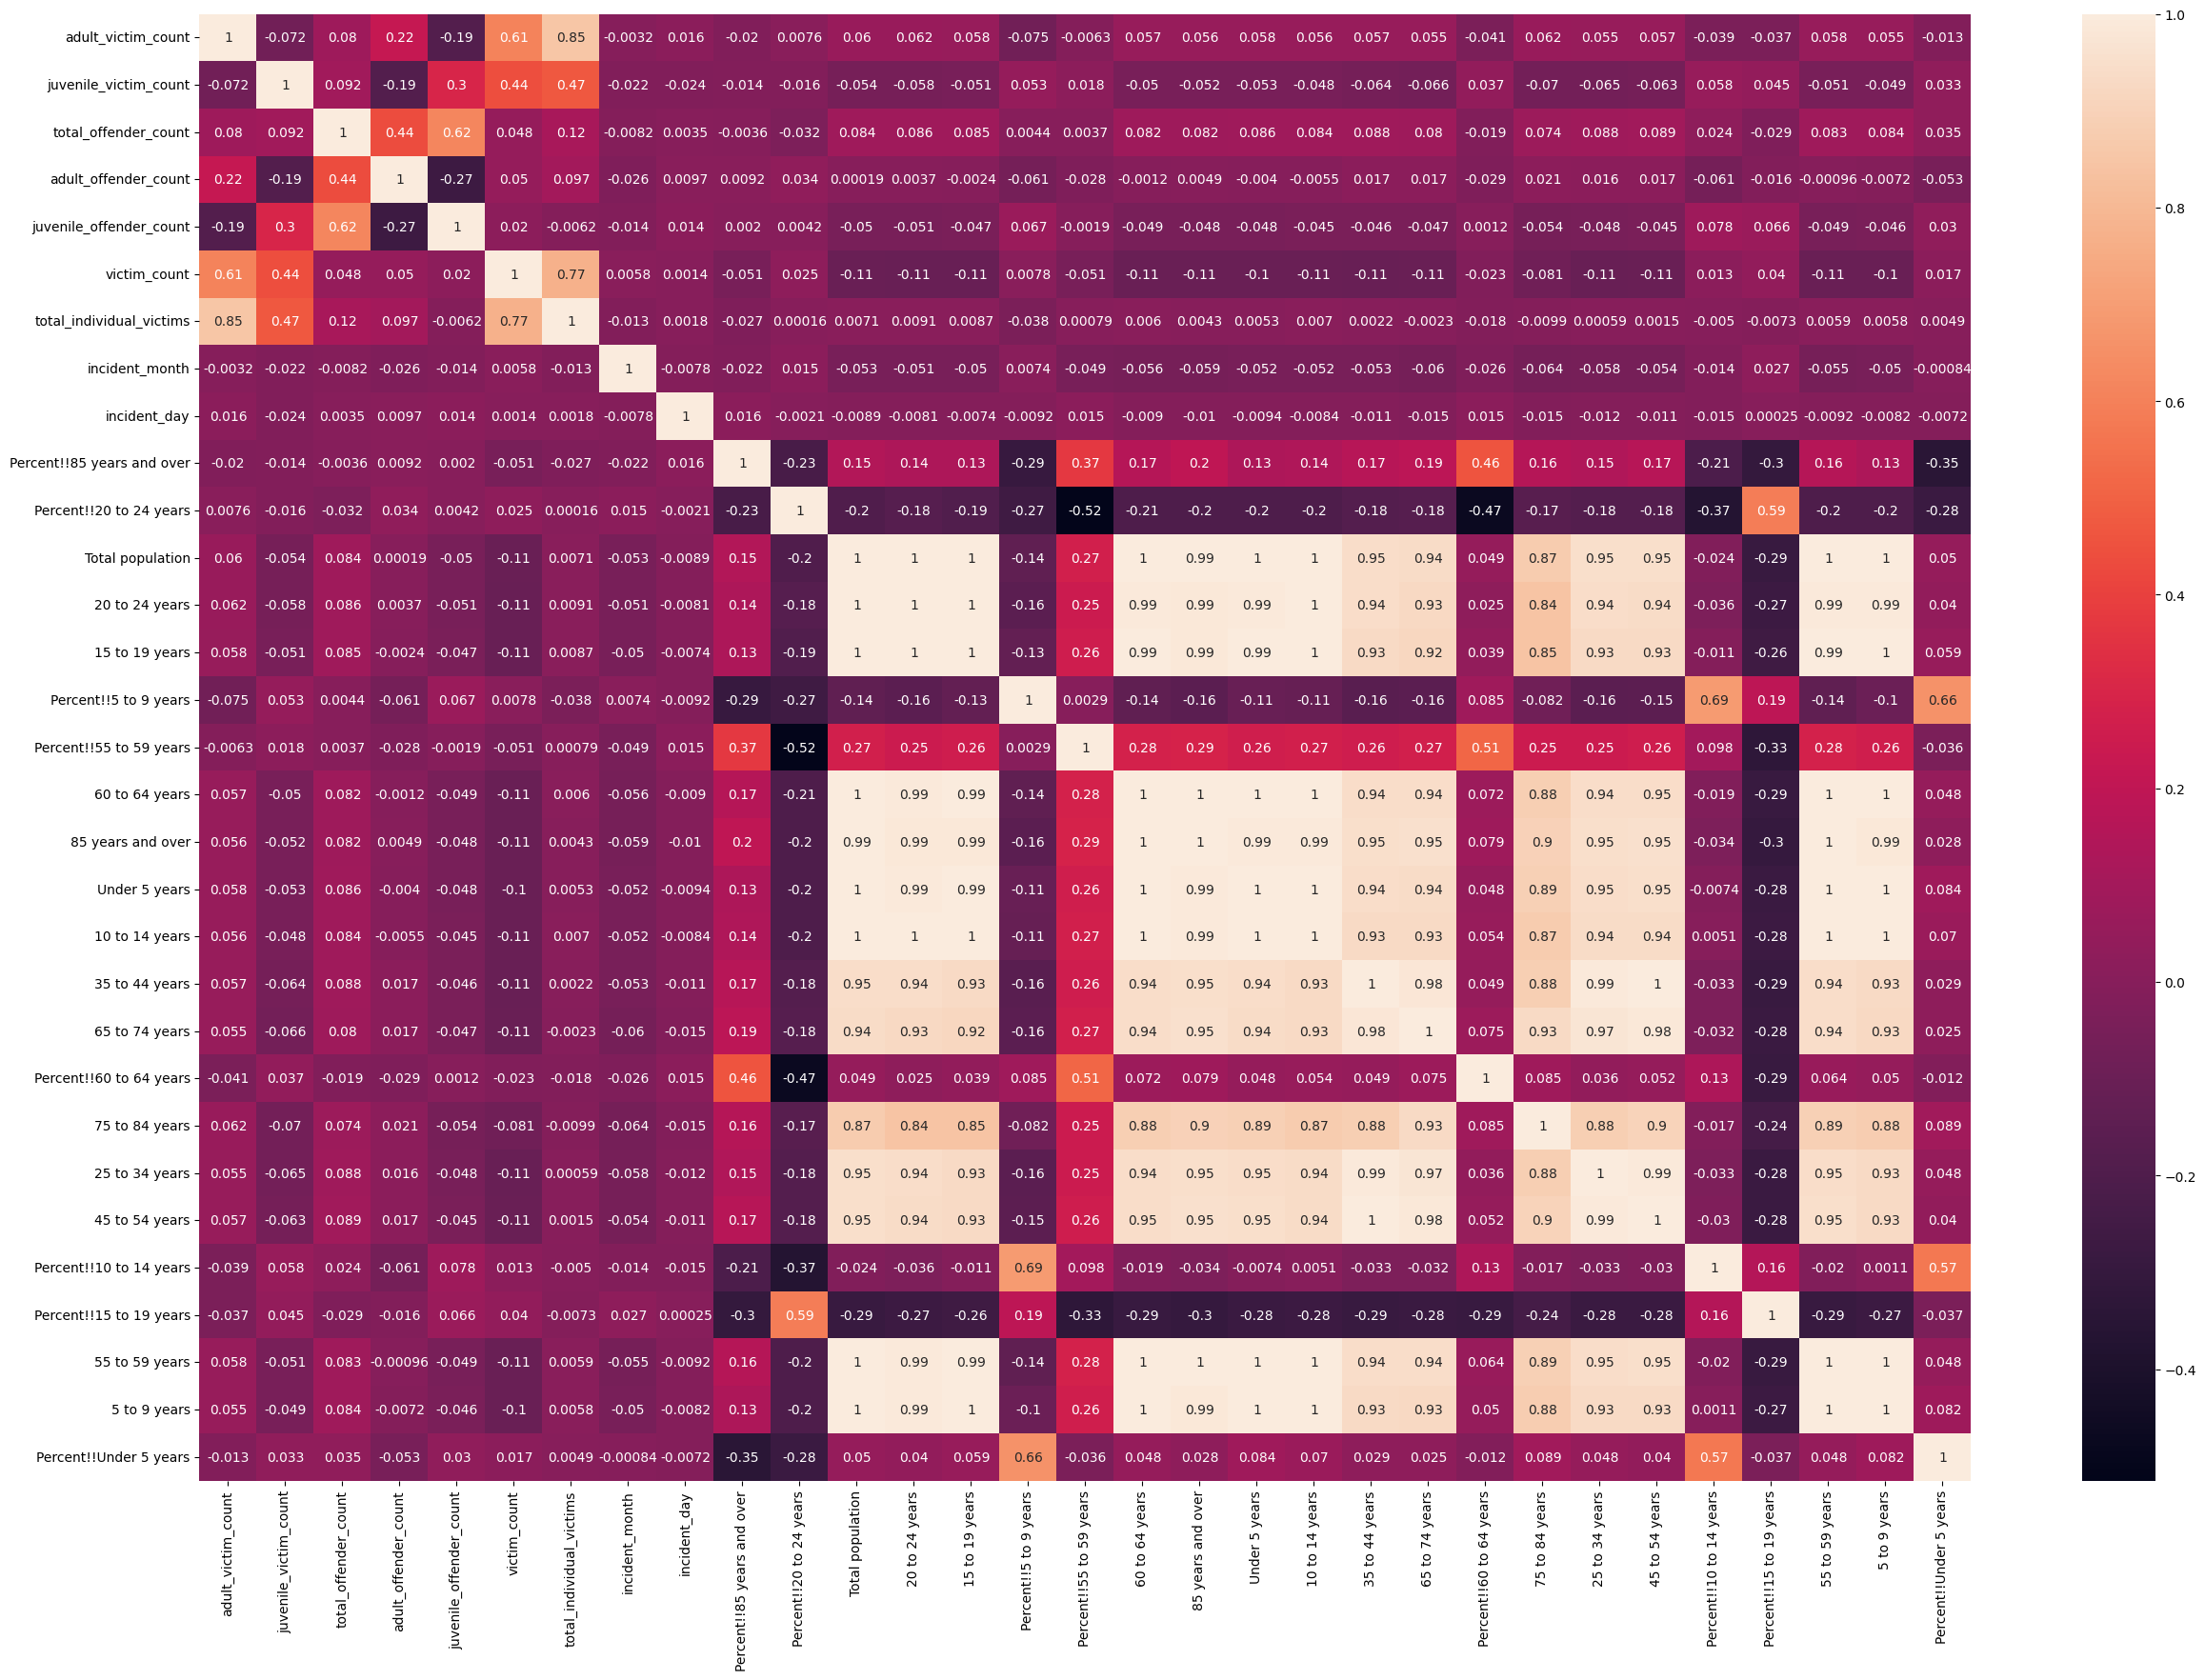

In [28]:
# Create a correlation matrix
corr = merged_df[numerical_cols.columns].corr()

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(corr, annot=True, ax=ax)

In [55]:
merged_df["color"] = merged_df["region_name"].map({
    "Midwest": "red",
    "West": "yellow",
    "Northeast": "green",
    "South": "blue"
})
merged_df["size"] = merged_df.groupby(["incident_month", "region_name"]).count().reset_index()["incident_id"]

#remove the max row limit for altair
alt.data_transformers.disable_max_rows()

alt.Chart(merged_df.dropna()).mark_circle().encode(
    x="total_offender_count",
    y="total_individual_victims",
    color=alt.Color("color", scale=None),
    size="size"
)

alt.Chart(...)